# importing libraries 

In [4]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# loading datasets

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# performing-EDA 

## checking missing values 

In [24]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

## visualize target variables 

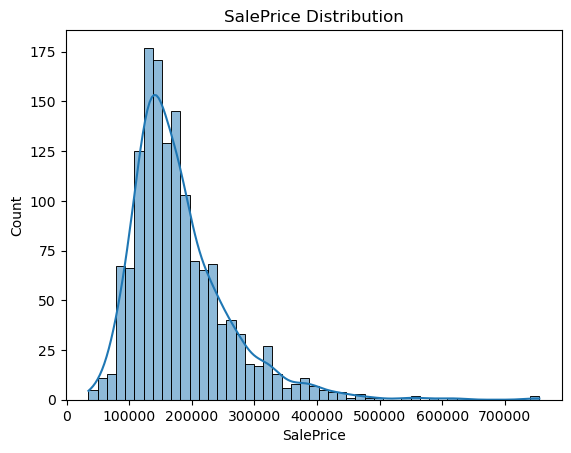

In [26]:
sns.histplot(train['SalePrice'], kde=True)
plt.title("SalePrice Distribution")
plt.show()


## correlation heatmaps 

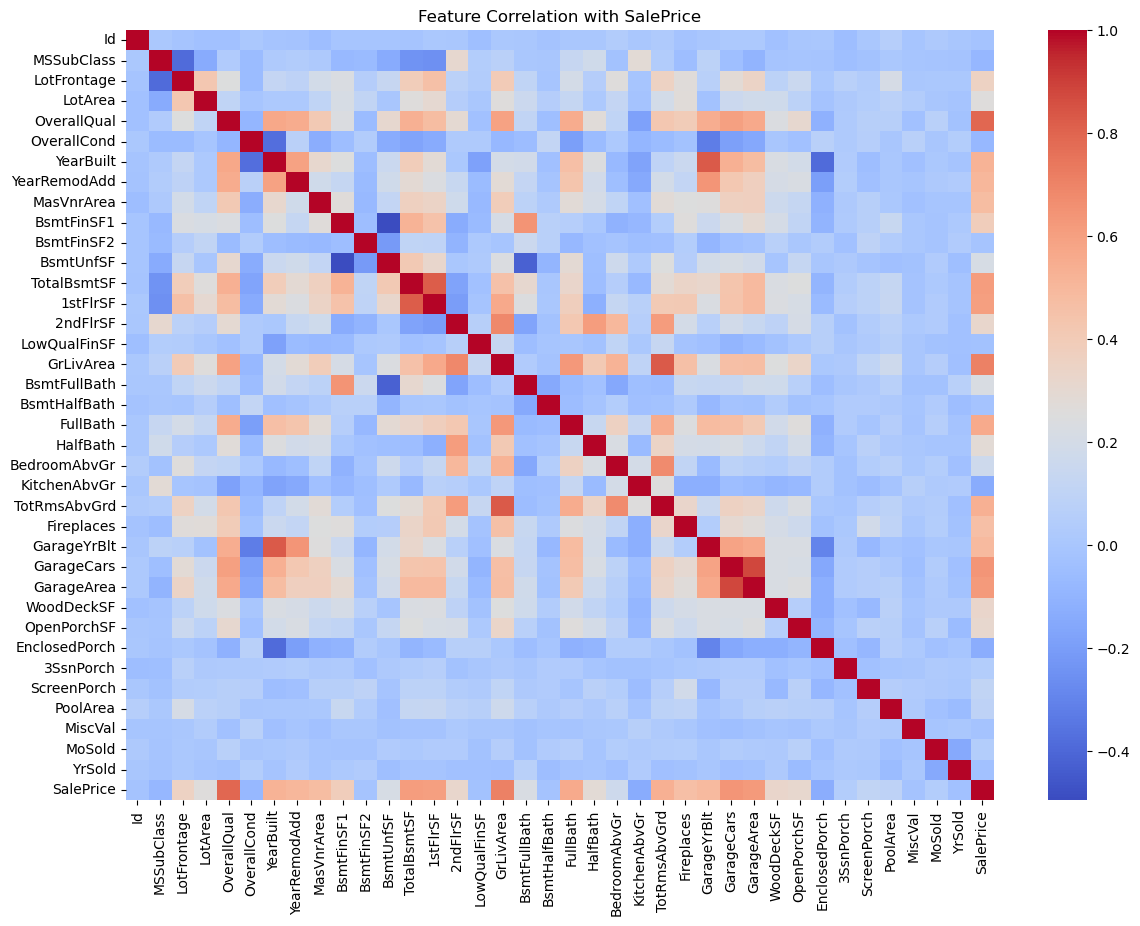

In [34]:
plt.figure(figsize=(14, 10))

# Select only numeric columns
numeric_data = train.select_dtypes(include=[np.number])

# Now compute correlation on numeric data only
sns.heatmap(numeric_data.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation with SalePrice")
plt.show()


## Top Features Correlated with SalePrice


In [36]:
# Use only numeric columns for correlation
numeric_train = train.select_dtypes(include=[np.number])

# Now compute correlation safely
corr_matrix = numeric_train.corr()

# Sort correlation with SalePrice
top_corr = corr_matrix["SalePrice"].sort_values(ascending=False)

# Show top 10 features most correlated with SalePrice
print(top_corr.head(10))


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


# data cleaning 

## Drop Columns with Too Many Missing Values


In [40]:
cols_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)


## fill missing numeric values with median 

In [43]:
num_cols = train.select_dtypes(include=[np.number]).columns

for col in num_cols:
    if train[col].isnull().sum() > 0:
        train[col] = train[col].fillna(train[col].median())
        
for col in num_cols:
    if col in test.columns and test[col].isnull().sum() > 0:
        test[col] = test[col].fillna(test[col].median())


## fill categorial missing  values with mode 

In [46]:
cat_cols = train.select_dtypes(include='object').columns

for col in cat_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
    
for col in test.select_dtypes(include='object').columns:
    test[col] = test[col].fillna(test[col].mode()[0])


# FEATURE ENGINERRING 

## Combine Train and Test for Consistent Encoding

In [50]:
train_labels = train['SalePrice']
train_features = train.drop(['SalePrice', 'Id'], axis=1)
test_features = test.drop(['Id'], axis=1)

combined = pd.concat([train_features, test_features], axis=0)


## LABEL ENCODING CATEGORICAL FEATURES 

In [53]:
le = LabelEncoder()

for col in combined.select_dtypes(include='object').columns:
    combined[col] = le.fit_transform(combined[col].astype(str))


## split combined data back 

In [57]:
X_train = combined[:len(train)]
X_test = combined[len(train):]
y_train = train_labels


# model building 

 ## Train/Test Split for Evaluation

In [61]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## linear regession model  

In [65]:
lr = LinearRegression()
lr.fit(X_tr, y_tr)

y_pred = lr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)


Validation RMSE: 34423.87660223425


# predict on test set 

In [68]:
test_preds = lr.predict(X_test)

submission = pd.DataFrame({
    "Id": test['Id'],
    "SalePrice": test_preds
})

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")


Saved submission.csv


#  final checking 

In [70]:
print(train.isnull().sum().sum())  # should be 0 or very small


0


In [76]:
submission = pd.read_csv('submission.csv')
print(submission.head())
print(submission.shape)


     Id      SalePrice
0  1461  107007.252145
1  1462  151881.286151
2  1463  165527.855071
3  1464  181811.353850
4  1465  191000.572896
(1459, 2)


In [78]:
print(submission.dtypes)


Id             int64
SalePrice    float64
dtype: object
